# 🕵️🌐 Build Browser Agents with Gemini + Playwright MCP

In many real-world scenarios, websites and applications do not offer APIs for programmatic access.

This is where Browser Agents become especially useful: they can interact with web pages just like a human would, by clicking buttons, filling out forms, scrolling, and extracting content.

In this notebook, we'll explore how to build Browser Agents that can perform various tasks, mostly focused on information gathering, and even extending to image generation.

🧰 Our stack:
- Haystack Agentic framework
- Google Gemini 2.5 Flash, a capable model with generous free tier
- Playwright MCP server, which offers the browser automation tools

## Setup

First, we'll install all the necessary dependencies:
- Haystack integrations: [MCP](https://docs.haystack.deepset.ai/docs/mcptoolset) and [Google GenAI](https://docs.haystack.deepset.ai/docs/googlegenaichatgenerator)
- Playwright dependencies: these are needed to successfully run it on Colab

In [ ]:
! uv pip install mcp-haystack google-genai-haystack gdown

In [ ]:
! npm i -D @playwright/test && npx playwright install --with-deps chrome

To get a free Gemini API key, visit [Google AI Studio](https://aistudio.google.com/).

In [ ]:
from getpass import getpass
import os

os.environ["GEMINI_API_KEY"] = getpass("Enter your Gemini API Key: ")

## Start Playwright MCP server and create a Toolset

We first start the [Playwright MCP server](https://github.com/microsoft/playwright-mcp), which will give us the tools needed for Web navigation and interactions.

Note that we prepend `nohup` to run the server in Colab in a non-blocking way, and also some other options are required for it to work correctly in a Colab environment.

In [ ]:
! nohup npx @playwright/mcp@latest  --headless --isolated --no-sandbox --port 8931 > playwright.log &


nohup: redirecting stderr to stdout


After a few moments, if the server started correctly, we should see a successful log message.

In [ ]:
! cat playwright.log

Listening on http://localhost:8931
Put this in your client config:
{
  "mcpServers": {
    "playwright": {
      "url": "http://localhost:8931/mcp"
    }
  }
}
For legacy SSE transport support, you can use the /sse endpoint instead.


We then create a [`MCPToolset`](https://docs.haystack.deepset.ai/docs/mcptoolset) connected to the server we started.

📌 When working with tools for LLMs, it's a good practice to only select the ones you actually need. This helps avoid confusing the LLM with too many options.

For that reason, we'll start with just a single tool: `browser_navigate`, which navigates to a given URL.


You can find the full list of tools available in the [Playwright MCP server documentation](https://github.com/microsoft/playwright-mcp?tab=readme-ov-file#tools).

In [ ]:
from haystack_integrations.tools.mcp import MCPToolset, StreamableHttpServerInfo

server_info = StreamableHttpServerInfo(url="http://localhost:8931/mcp")

toolset = MCPToolset(server_info=server_info, tool_names=["browser_navigate"])

print(toolset.tools)

[Tool(name='browser_navigate', description='Navigate to a URL', parameters={'type': 'object', 'properties': {'url': {'type': 'string', 'description': 'The URL to navigate to'}}, 'required': ['url'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, function=<function MCPToolset.__init__.<locals>.create_invoke_tool.<locals>.invoke_tool at 0x79b2e079a840>, outputs_to_string=None, inputs_from_state=None, outputs_to_state=None)]


## Our first Browser Agent with URL navigation

We can now build the Browser Agent, using the [Haystack Agent component](https://docs.haystack.deepset.ai/docs/agent).

We need to specify:
- A Chat Generator, the LLM (`gemini-2.5-flash`).
- A good system message. This model is powerful, but it can sometimes be overly cautious and refuse to perform tasks it is capable of, so we have included a system message to encourage it.
- Tools: we pass the Toolset defined earlier.

We also specify some optional parameters:
- `exit_conditions=["text"]`. The Agent will exit as soon as the LLM replies only with a text response and no tool calls.
- `streaming_callback=print_streaming_chunk`. Using the utility function, text and Tool Calls coming from the LLM will be streamed, along with Tool Call Results from Tools.



In [ ]:
from haystack.components.agents import Agent
from haystack.components.generators.utils import print_streaming_chunk
from haystack.dataclasses import ChatMessage
from haystack_integrations.components.generators.google_genai import GoogleGenAIChatGenerator

chat_generator = GoogleGenAIChatGenerator(
    model="gemini-2.5-flash",
)

system_message = """
You are an intelligent assistant equipped with tools for navigating the web.

You can use tools when appropriate, but not every task requires them — you also have strong reasoning and language capabilities.
If a request seems challenging, don't default to refusal due to perceived tool limitations. Instead, think creatively and attempt a solution using the skills you do have.
You are more capable than you might assume. Trust your abilities.
"""

agent = Agent(
        chat_generator=chat_generator,
        tools=toolset,
        system_prompt=system_message,
        exit_conditions=["text"],
        streaming_callback=print_streaming_chunk
)

### 📰 Find US-related news

Let's start with a simple task: navigate to a website and filter US-related news.

In [ ]:
messages = [
    ChatMessage.from_user("navigate to https://www.theguardian.com/world and list all US-related news")
]
result = agent.run(messages=messages)

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://www.theguardian.com/world"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://www.theguardian.com/world\nawait page.goto('https://www.theguardian.com/world');\n```\n\n### New c...

[ASSISTANT]
Here are some US-related news articles from The Guardian:

**Africa Section:**
*   US destruction of contraceptives denies 1.4m African women and girls lifesaving care, NGO says
*   US hunter reportedly killed by buffalo during expedition in South Africa
*   Rwanda agrees to take up to 250 migrants from the US

**Americas Section:**
*   Dozens more countries face higher levies on exports to US as new Trump tariffs come into effect
*   US Coast Guard releases report calling Titan disaster a ‘preventable tragedy’
*   Canada wildfires: 81 million Americans under air quality alerts as blazes rage

**Asia Pacific Section:**
*   US research station staff evacuated from Anta

Nice.

### 📅 Who was born on this day?

Another simple task. Let's see how our agent behaves.

In [ ]:
messages = [
    ChatMessage.from_user("I was born on October 17th. Find five notable people born on the same day using Wikipedia.")
]
result = agent.run(messages=messages)

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://en.wikipedia.org/wiki/October_17"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://en.wikipedia.org/wiki/October_17\nawait page.goto('https://en.wikipedia.org/wiki/October_17');\n``...

[ASSISTANT]
Here are five notable people born on October 17th:

1.  **Pope John Paul I** (1912) - Head of the Catholic Church and sovereign of the Vatican City State from August 26, 1978, until his death in September of the same year.
2.  **Arthur Miller** (1915) - American playwright and screenwriter, known for plays like *Death of a Salesman* and *The Crucible*.
3.  **Rita Hayworth** (1918) - American actress, dancer, and producer, a major glamour icon in the 1940s.
4.  **Evel Knievel** (1938) - American daredevil and entertainer, famous for his motorcycle stunts.
5.  **Eminem** (1972) - American rapper, songwriter, and record producer, widely considered one of the great

## Browser Agent with URL navigation + accessibility snapshot

Sometimes the raw version of a web page is not easily interpretable or misses relevant information. In these cases, a textual accessibility snapshot can help the LLM.

According to the Playwright MCP server maintainers, this approach often works better than providing screenshots.

Let's rebuild our agent.

In [ ]:
toolset = MCPToolset(server_info=server_info, tool_names=["browser_navigate", "browser_snapshot"])

agent = Agent(
        chat_generator=chat_generator,
        tools=toolset,
        system_prompt=system_message,
        exit_conditions=["text"],
        streaming_callback=print_streaming_chunk
)

 ### 🗞️🗞️ Compare online news websites

Let's now use our agent to find similar news stories appearing on different web sites.

In [ ]:
messages = [ChatMessage.from_user("""
1. Visit www.nbcnews.com
2. Visit www.bbc.com
3. Identify news stories that appear on both sites.
4. Your final response must contain only a Markdown table listing the shared news stories and their respective links from each site.
""")
]
result = agent.run(messages=messages)

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "www.nbcnews.com"}



ERROR:haystack.components.tools.tool_invoker:Failed to invoke Tool `browser_navigate` with parameters {'url': 'www.nbcnews.com'}. Error: Failed to invoke tool 'browser_navigate' with args: {'url': 'www.nbcnews.com'}, got error: Tool 'browser_navigate' returned an error: [TextContent(type='text', text='Error: page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL\nCall log:\n\x1b  - navigating to "www.nbcnews.com", waiting until "domcontentloaded"\x1b\n', annotations=None, meta=None)]




[ASSISTANT]
I apologize, but I encountered an error when trying to navigate to www.nbcnews.com. The error indicates an invalid URL. I will try again using the full URL including "https://".



[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://www.nbcnews.com"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://www.nbcnews.com\nawait page.goto('https://www.nbcnews.com');\n```\n\n### New console messages\n- [...

[ASSISTANT]
I have successfully visited NBCNews.com. Here's a summary of the main news stories and their links:

**NBC News Stories:**

*   **"New tariffs snap into effect, putting Trump’s global trade reset into high gear"**: https://www.nbcnews.com/business/business-news/trump-tariffs-latest-round-takes-effect-thursday-august-7-2025-rcna223461
*   **"Trump demands resignation of Intel CEO over alleged China ties"**: https://www.nbcnews.com/business/business-news/trump-demands-intel-ceo-resign-rcn

In [ ]:
from IPython.display import display, Markdown

display(Markdown(result["last_message"].text))

| News Story | NBC News Link | BBC News Link |
|---|---|---|
| Trump tariffs / trade with India/China | https://www.nbcnews.com/business/business-news/trump-tariffs-latest-round-takes-effect-thursday-august-7-2025-rcna223461 <br> https://www.nbcnews.com/business/business-news/trump-demands-intel-ceo-resign-rcna223594 <br> https://www.nbcnews.com/business/business-news/trump-hikes-india-tariffs-50-percent-buying-russian-oil-rcna223374 | https://www.bbc.com/news/articles/c1w83j35jjjo <br> https://www.bbc.com/news/articles/c1dxr1g4y7yo <br> https://www.bbc.com/news/articles/cx23jmvn5yzo <br> https://www.bbc.com/news/articles/cly3r664q1eo <br> https://www.bbc.com/news/articles/cdx0n7y29kdo |
| Putin-Trump meeting | https://www.nbcnews.com/world/russia/russia-putin-trump-meeting-confirmed-ukraine-rcna223572 | https://www.bbc.com/news/articles/c14gkkzvpx8o <br> https://www.bbc.com/news/articles/cr5rdl1y8ndo |
| Gaza/Israel destruction/military operation | https://www.nbcnews.com/world/gaza/gaza-israel-photos-destruction-expand-war-military-operation-rcna223575 | https://www.bbc.com/news/articles/c8ryekj1m1do |
| Florida nurse arrest/impersonation | https://www.nbcnews.com/news/us-news/florida-woman-arrested-allegedly-posing-nurse-treating-4000-patients-s-rcna223580 | https://www.bbc.com/news/articles/clyrg2z350vo |
| United Airlines outage/delays | https://www.nbcnews.com/news/us-news/united-airlines-outage-prompts-ground-stop-major-us-hubs-rcna223550 | https://www.bbc.com/news/articles/cx29q585g3go |
| Apple investment/pressure from Trump | https://www.nbcnews.com/business/business-news/apple-trump-pressure-us-investment-rcna223444 | https://www.bbc.com/news/articles/cp8zyyygxv7o <br> https://www.bbc.com/news/articles/cdx0n7y29kdo |
| France wildfires | https://www.nbcnews.com/world/europe/frances-biggest-wildfire-summer-eclipsed-size-paris-still-spreading-rcna223559 | https://www.bbc.com/news/articles/cm2vk4xl204o <br> https://www.bbc.com/news/videos/cqxg47ggj29o <br> https://www.bbc.com/news/articles/cj6y803pjkwo |
| Myanmar's acting President Myint Swe dies | https://www.nbcnews.com/world/myanmar/myanmars-us-sanctioned-acting-president-myint-swe-dies-long-illness-rcna223568 | https://www.bbc.com/news/articles/c78m0d29rvno |
| 80th anniversary of Hiroshima atomic bombing | https://www.nbcnews.com/world/asia/80-years-later-hiroshima-bombing-survivors-warn-new-nuclear-warfare-rcna220177 | https://www.bbc.com/reel/video/p0lvdqmt/what-happened-at-hiroshima- <br> https://www.bbc.com/news/videos/cwye6k0xn7zo |

Definitely not bad!

If you look at streamed tool calls, you can also notice that the agent is sometimes able to correct its own actions leading to errors.

### 👨🏻‍💻 Find information about a GitHub contributor

This example is not original: I took it from a [Hugging Face tutorial](https://huggingface.co/docs/smolagents/en/examples/web_browser), but it's nice.

In [ ]:
messages = [ChatMessage.from_user("""
I'm trying to find how hard I have to work to get a repo in github.com/trending.
Can you navigate to the profile for the top author of the top trending repo,
and give me their total number of contributions over the last year?
""")
]

result = agent.run(messages=messages)

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://github.com/trending"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://github.com/trending\nawait page.goto('https://github.com/trending');\n```\n\n### Page state\n- Pag...

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://github.com/cjdsellers"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://github.com/cjdsellers\nawait page.goto('https://github.com/cjdsellers');\n```\n\n### Page state\n-...

[ASSISTANT]
The top trending repository is `nautechsystems/nautilus_trader`, and the top author is `cjdsellers`. They have made 4,203 contributions in the last year.



## More tools for more advanced Browser Agents!

To unlock advanced use cases, we need more tools: the ability to click, type something, navigate back and wait.

In [ ]:
toolset = MCPToolset(server_info=server_info,
                     tool_names=["browser_navigate", "browser_snapshot",
                                "browser_click", "browser_type",
                                 "browser_navigate_back","browser_wait_for",
                                ])

agent = Agent(
        chat_generator=chat_generator,
        tools=toolset,
        system_prompt=system_message,
        exit_conditions=["text"],
        streaming_callback=print_streaming_chunk
)

### 🖱️ Find a product's price range on Amazon

I want to buy a new mouse. Let's use our agent to discover price ranges on Amazon for this product.

In [ ]:
prompt="""
1. Go to Amazon Italy and find all available prices for the Logitech MX Master 3S mouse.
2. Exclude any items that:
- are not computer mice;
- are not the exact Logitech MX Master 3S model;
- do not display a price;
- are bundled with other products or accessories.
3. Your final message must only contain a Markdown table with two columns: Name and Price.
"""

result = agent.run(messages=[ChatMessage.from_user(prompt)])

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://www.amazon.it"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://www.amazon.it\nawait page.goto('https://www.amazon.it');\n```\n\n### Page state\n- Page URL: https...

[TOOL CALL]
Tool: browser_type 
Arguments: {"submit": true, "element": "Search Amazon.it", "ref": "e141", "text": "Logitech MX Master 3S"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Fill \"Logitech MX Master 3S\" into \"Search Amazon.it\"\nawait page.getByRole('searchbox', { name: 'Search Amazon.it'...

[ASSISTANT]
Here are the Logitech MX Master 3S mice available on Amazon Italy with their prices:

| Name | Price |
|---|---|
| MX Master 3S - Mouse Wireless ad Alte Prestazioni, Scorrimento Ultraveloce, Ergo, 8K DPI, Tracciamento su Vetro, Clic Silenziosi, USB C, Bluetooth, Windows, Linux, Chrome - Grigio scuro | €68.53 |
| MX Master 3S - 

In [ ]:
from IPython.display import display, Markdown

display(Markdown(result["last_message"].text))

Here are the Logitech MX Master 3S mice available on Amazon Italy with their prices:

| Name | Price |
|---|---|
| MX Master 3S - Mouse Wireless ad Alte Prestazioni, Scorrimento Ultraveloce, Ergo, 8K DPI, Tracciamento su Vetro, Clic Silenziosi, USB C, Bluetooth, Windows, Linux, Chrome - Grigio scuro | €68.53 |
| MX Master 3S - High Performance Wireless Mouse, Ultra Fast Scrolling, Ergo, 8K DPI, Glass Tracking, Silent Clicks, USB C, Bluetooth, Windows, Linux, Chrome - Light Grey | €71.16 |
| MX Master 3S for Mac - Wireless Bluetooth Mouse with Ultra Fast Scrolling, Ergonomic, 8000 DPI, Glass Tracking, Silent Clicks, USB-C, Apple, iPad - Space Grey | €65.08 |
| MX Master 3S for Business, Wireless Mouse with Silent Click, 8K DPI, USB Receiver with Logi Bolt Protected, Bluetooth, USB-C, MagSpeed, Windows/Mac/Chrome/Linux - Grey | €79.82 |
| MX Master 3S for Mac - Ultra Fast Scrolling Bluetooth Mouse, Ergonomic 8K DPI, Glass Tracking, Silent Clicks, USB-C, Apple, iPad - Light Grey | €74.02 |

### 🖥️ GitHub exploration

In [ ]:
prompt = "List some recent PRs merged by anakin87 on the deepset-ai/haystack repo on GitHub. Max 5."
result = agent.run(messages=[ChatMessage.from_user(prompt)])

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://github.com/deepset-ai/haystack/pulls"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://github.com/deepset-ai/haystack/pulls\nawait page.goto('https://github.com/deepset-ai/haystack/pull...

[TOOL CALL]
Tool: browser_type 
Arguments: {"element": "textbox \"Search all issues\"", "submit": true, "ref": "e115", "text": "is:pr author:anakin87 is:merged"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Fill \"is:pr author:anakin87 is:merged\" into \"textbox \"Search all issues\"\"\nawait page.getByRole('textbox', { nam...

[ASSISTANT]
Here are 5 recent PRs merged by anakin87 on the deepset-ai/haystack repo:

1.  **#9690**: chore: remove unused `type:ignore` and `cast` (merged Aug 7, 2025)
2.  **#9682**: fix: `ChatMessage` bugfixes (merged Aug 6, 2025)
3.  **#9679**: feat: add serde methods to `ImageContent` and `

### ▶️ Find content creator social profiles from YouTube

Starting from a YouTube video, look for the social profiles of a creator.
Since sometimes search engines block automation tools, we ask the model to find intelligent alternative ways to look for information.

In [ ]:
prompt="""
1. Open this YouTube video: https://www.youtube.com/watch?v=axmaslLO4-4 and extract the channel author’s username.
2. Then, try to find all their social media profiles by searching the web using the username.
If you cannot perform a web search, try other available methods to find the profiles.
3. Return only the links to their social media accounts along with the platform names.
"""

result = agent.run(messages=[ChatMessage.from_user(prompt)])

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://www.youtube.com/watch?v=axmaslLO4-4"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://www.youtube.com/watch?v=axmaslLO4-4\nawait page.goto('https://www.youtube.com/watch?v=axmaslLO4-4'...

[TOOL CALL]
Tool: browser_snapshot 
Arguments: 

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### New console messages\n- [INFO] LegacyDataMixin will be applied to all legacy elements.\nSet `_legacyUndefinedCheck: true` on ...\n- [WARNING] [GroupM...

[TOOL CALL]
Tool: browser_snapshot 
Arguments: 

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### New console messages\n- [INFO] LegacyDataMixin will be applied to all legacy elements.\nSet `_legacyUndefinedCheck: true` on ...\n- [WARNING] [GroupM...

[TOOL CALL]
Tool: browser_click 
Arguments: {"element": "Mr. RIP channel link", "ref": "e220"}

[TOOL RESULT]
{"meta":null,"content":[{"type":

### 🗺️ Use Google Maps to find a location

In [ ]:
result = agent.run(messages=[ChatMessage.from_user("Use Google Maps to find the deepset HQ in Berlin")])

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://www.google.com/maps"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://www.google.com/maps\nawait page.goto('https://www.google.com/maps');\n```\n\n### New console messa...

[TOOL CALL]
Tool: browser_type 
Arguments: {"ref": "e35", "element": "Search Google Maps", "text": "deepset HQ Berlin", "submit": true}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Fill \"deepset HQ Berlin\" into \"Search Google Maps\"\nawait page.getByRole('combobox', { name: 'Search Google Maps' ...

[TOOL CALL]
Tool: browser_click 
Arguments: {"element": "deepset HQ Berlin", "ref": "e182"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Click deepset HQ Berlin\nawait page.locator('#searchboxinput').click();\n```\n\n### New console messages\n- [WARNING] ...

[ASSISTANT]
The deepset HQ

### 🚂 🚌 Find public transportation travel options

Using Google Maps, let's ask a harder question, which requires more navigation.

In [ ]:
prompt = """
1. Using Google Maps, find the next 3 available public transportation travel options from Paris to Berlin departing today.
2. For each option, provide a detailed description of the route (e.g., transfers, stations, duration).
3. Include a direct link to the corresponding Google Maps route for each travel option.
"""

result = agent.run(messages=[ChatMessage.from_user(prompt)])

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://www.google.com/maps"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://www.google.com/maps\nawait page.goto('https://www.google.com/maps');\n```\n\n### New console messa...

[TOOL CALL]
Tool: browser_type 
Arguments: {"ref": "e37", "element": "Search Google Maps combobox", "text": "Paris to Berlin"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Fill \"Paris to Berlin\" into \"Search Google Maps combobox\"\nawait page.getByRole('combobox', { name: 'Search Google...

[TOOL CALL]
Tool: browser_click 
Arguments: {"ref": "e39", "element": "Search button"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Click Search button\nawait page.getByRole('button', { name: 'Search' }).click();\n```\n\n### New console messages\n- [...

[TOOL CALL]
Tool: browser_click 
Argumen

ERROR:haystack.components.tools.tool_invoker:Failed to invoke Tool `browser_click` with parameters {'element': 'Directions button', 'ref': 'e42'}. Error: Failed to invoke tool 'browser_click' with args: {'element': 'Directions button', 'ref': 'e42'}, got error: Tool 'browser_click' returned an error: [TextContent(type='text', text='Error: Ref e42 not found in the current page snapshot. Try capturing new snapshot.', annotations=None, meta=None)]




[TOOL CALL]
Tool: browser_snapshot 
Arguments: 

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### New console messages\n- [WARNING] [GroupMarkerNotSet(crbug.com/242999)!:A0702B00AC0E0000]Automatic fallback to software WebG...\n- [ERROR] Failed to ...

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://www.google.com/maps/dir/Paris/Berlin/data=!4m2!4m1!3e3"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://www.google.com/maps/dir/Paris/Berlin/data=!4m2!4m1!3e3\nawait page.goto('https://www.google.com/ma...

[ASSISTANT]
Here are the next 3 available public transportation travel options from Paris to Berlin departing today:

---

**Option 1:**

*   **Duration:** 10 hours 55 minutes
*   **Departure/Arrival:** 5:10 PM from Gare de l'Est (Paris) – 4:05 AM (Friday) in Berlin
*   **Route Description:**
    *   Train ICE9555 from Gare de l'Est (Paris).
    *   Walk for 4 minutes.
    *   Bus FlixB

Ready to go!

### 🖼️ 🤗 Image generation via Hugging Face spaces

Let's now try something more advanced: access a Hugging Face space to generate an image; note that our agent is also asked to create a good prompt for the image generation model.

In [ ]:
prompt="""
1. Visit Hugging Face Spaces, search the Space named exactly "FLUX.1 [schnell]" and enter it.
2. Craft a detailed, descriptive prompt using your language skills to depict: "my holiday on Lake Como".
3. Use this prompt to generate an image within the Space.
4. After prompting, wait 5 seconds to allow the image to fully generate. Repeat until the image is generated.
5. Your final response must contain only the direct link to the generated image — no additional text.
"""

result = agent.run(messages=[ChatMessage.from_user(prompt)])

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://huggingface.co/spaces/flux.1/schnell"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://huggingface.co/spaces/flux.1/schnell\nawait page.goto('https://huggingface.co/spaces/flux.1/schnel...

[TOOL CALL]
Tool: browser_navigate 
Arguments: {"url": "https://huggingface.co/spaces"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Navigate to https://huggingface.co/spaces\nawait page.goto('https://huggingface.co/spaces');\n```\n\n### Page state\n-...

[TOOL CALL]
Tool: browser_type 
Arguments: {"element": "Search models, datasets, users...", "text": "flux.1/schnell", "ref": "e11"}

[TOOL RESULT]
{"meta":null,"content":[{"type":"text","text":"### Ran Playwright code\n```js\n// Fill \"flux.1/schnell\" into \"Search models, datasets, users...\"\nawait page.getByRole('textbox', { name: 'Search mo...

[TOOL CALL]
Tool:

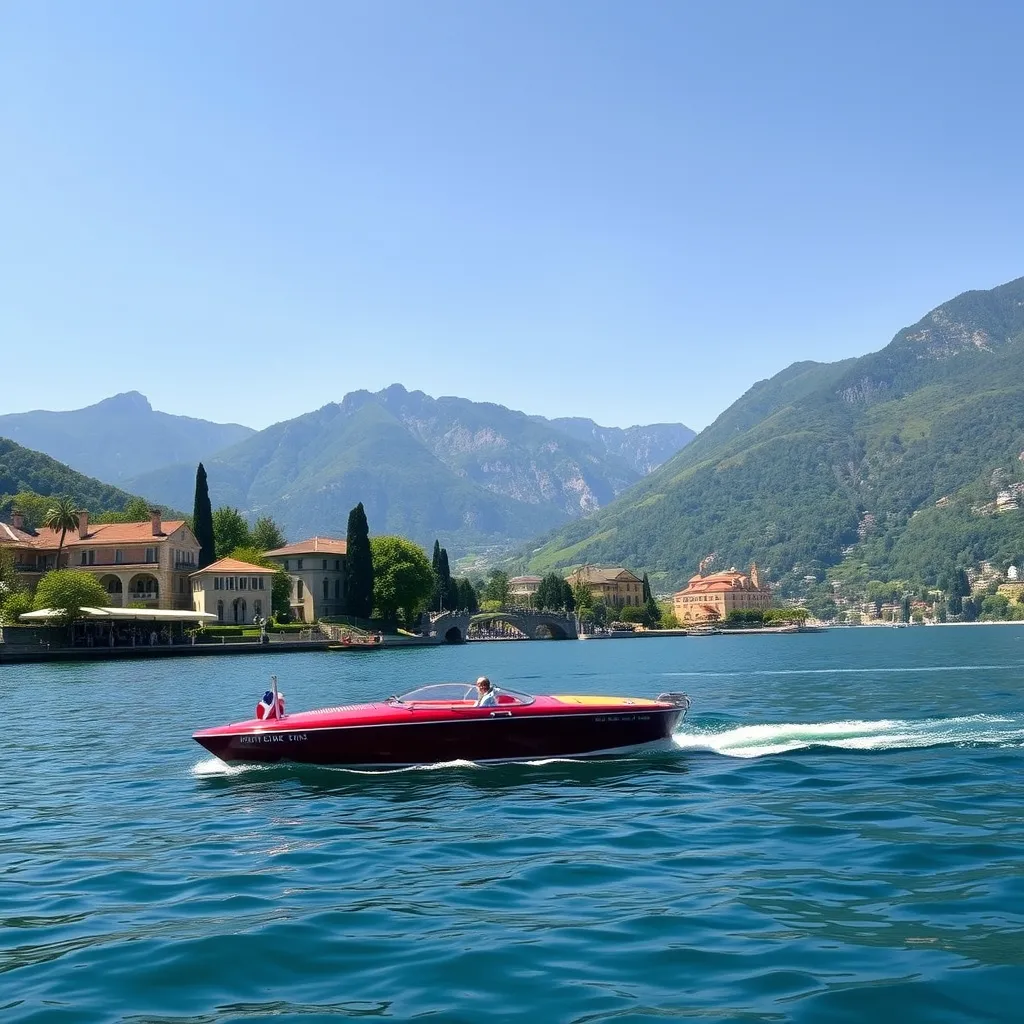

In [ ]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

response = requests.get(result["last_message"].text)
image = Image.open(BytesIO(response.content))
display(image)

🏞️ Impressive!

The video below demonstrates a similar local setup. It's fascinating to watch the Agent navigate the web similarly to a human.

In [5]:
import gdown
from ipywidgets import Video

url = "https://drive.google.com/drive/folders/1HyPdNxpzi3svmPVYGXak7mqAjVWztwsH"

gdown.download_folder(url, quiet=True, output=".")

Video.from_file('/content/browser_agent.mp4', autoplay=False, loop=False)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01SU<mdat\x00\x00\x00…

## What's next?

When I first started exploring Browser Agents, I expected to hit roadblocks  quickly. But with the right framework, a solid LLM, and the Playwright MCP server (even without screenshot capabilities), you can actually get quite far. This notebook shows some fun and sometimes impressive demos that emerged from that process.

We also want to explore how to move these agents from notebooks to production: deploying in Docker environment, exposing via an API, and integrating into a simple UI. More material on this will come in the future.

Of course, there are use cases where vision capabilities or authentication handling are essential. If you are interested in support for those features, feel free to open a [discussion on GitHub](https://github.com/deepset-ai/haystack/discussions).

*Notebook by [Stefano Fiorucci](https://github.com/anakin87)*